In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

/isis/home/hasana3/miniconda3/envs/clip_tracker_work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto").eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [3]:
def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [4]:
image = Image.open("../dataset/kitti/validation/image_02/0019/000046.png")

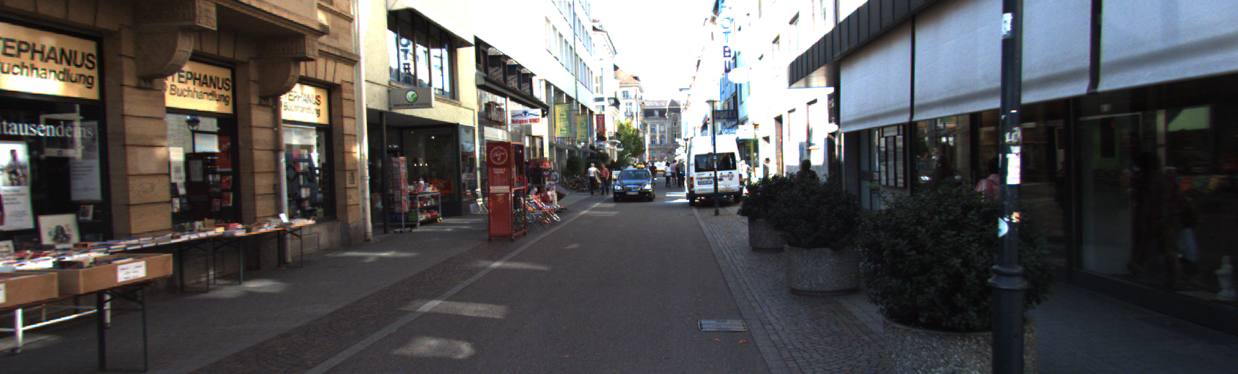

In [5]:
image

In [6]:
run_example(image, "<OD>")

{'<OD>': {'bboxes': [[0.6190000176429749,
    0.18700000643730164,
    1237.3809814453125,
    373.8130187988281],
   [0.6190000176429749,
    0.18700000643730164,
    651.8070068359375,
    373.43902587890625],
   [680.281005859375,
    0.18700000643730164,
    1237.3809814453125,
    373.43902587890625],
   [607.239013671875,
    168.11300659179688,
    659.2350463867188,
    201.77301025390625]],
  'labels': ['building', 'building', 'building', 'land vehicle']}}

In [7]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

def plot_bbox_raw(image, bbox, ax=None, fig=None):
    show_image = False
    # Create a figure and axes  
    if ax is None:
       fig, ax = plt.subplots()
       show_image = True
        
     # Display the image
    if show_image:
         ax.imshow(image)

    # Unpack the bounding box coordinates
    x1, y1, x2, y2 = bbox
    # Create a Rectangle patch
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the Axes
    ax.add_patch(rect)  
        
    # Remove the axis ticks and labels  
    ax.axis('off')  
        
    return fig, ax
    
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        plot_bbox_raw(image, bbox, ax, fig)
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show() 

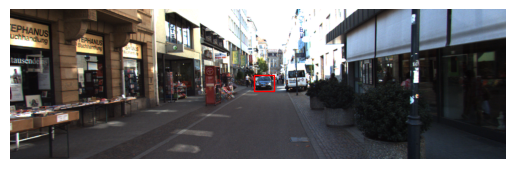

In [8]:
plot_bbox(image, run_example(image, "<CAPTION_TO_PHRASE_GROUNDING>", "A car down the street")["<CAPTION_TO_PHRASE_GROUNDING>"])

In [9]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

In [10]:
import numpy as np
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(image, task_prompt, text_input="a car down the street")
print(results)
print(np.array(results["<REFERRING_EXPRESSION_SEGMENTATION>"]["polygons"]).reshape(-1).shape)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[619.6190185546875, 169.98300170898438, 624.571044921875, 168.8610076904297, 630.7610473632812, 167.73899841308594, 644.3790283203125, 167.73899841308594, 646.8550415039062, 168.8610076904297, 649.3309936523438, 171.47900390625, 650.5690307617188, 174.0970001220703, 651.8070068359375, 177.83700561523438, 653.0450439453125, 181.57701110839844, 654.2830200195312, 190.55300903320312, 654.2830200195312, 196.9110107421875, 653.0450439453125, 199.5290069580078, 650.5690307617188, 200.6510009765625, 614.6669921875, 200.6510009765625, 613.4290161132812, 198.0330047607422, 612.1910400390625, 194.29299926757812, 610.9530029296875, 190.55300903320312, 610.9530029296875, 181.57701110839844, 612.1910400390625, 177.83700561523438, 614.6669921875, 175.21900939941406, 614.6669921875, 172.60101318359375, 617.1430053710938, 169.98300170898438]]], 'labels': ['']}}
(44,)


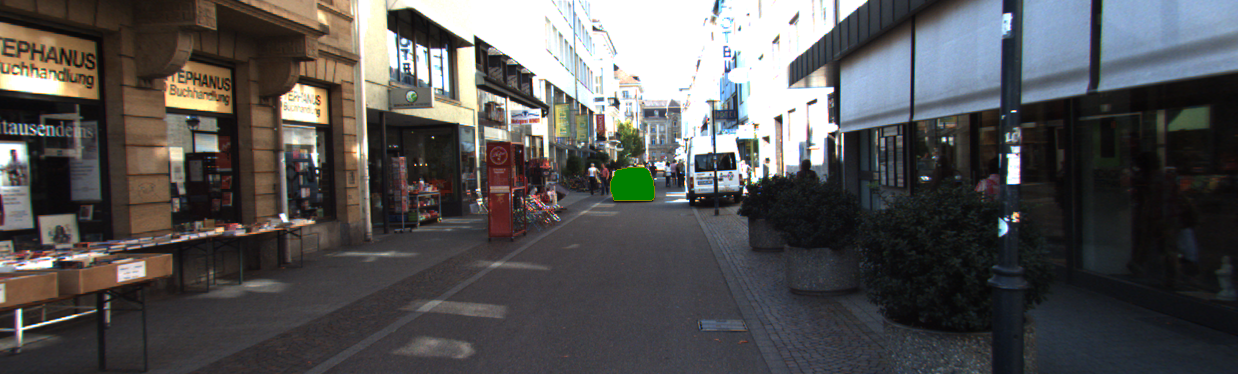

In [11]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True) 

In [12]:
def getBBOXFromPolygon(result_entry, margin_factor=0.05):
    polygon = np.array(result_entry["polygons"]).reshape(-1)
    x_min = np.min(polygon[0::2])
    y_min = np.min(polygon[1::2])
    x_max = np.max(polygon[0::2])
    y_max = np.max(polygon[1::2])
    x_margin = (x_max - x_min) * margin_factor
    y_margin = (y_max - y_min) * margin_factor
    return [x_min - x_margin, y_min - y_margin, x_max + x_margin, y_max + y_margin]

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[619.6190185546875, 169.98300170898438, 624.571044921875, 168.8610076904297, 630.7610473632812, 167.73899841308594, 644.3790283203125, 167.73899841308594, 646.8550415039062, 168.8610076904297, 649.3309936523438, 171.47900390625, 650.5690307617188, 174.0970001220703, 651.8070068359375, 177.83700561523438, 653.0450439453125, 181.57701110839844, 654.2830200195312, 190.55300903320312, 654.2830200195312, 196.9110107421875, 653.0450439453125, 199.5290069580078, 650.5690307617188, 200.6510009765625, 614.6669921875, 200.6510009765625, 613.4290161132812, 198.0330047607422, 612.1910400390625, 194.29299926757812, 610.9530029296875, 190.55300903320312, 610.9530029296875, 181.57701110839844, 612.1910400390625, 177.83700561523438, 614.6669921875, 175.21900939941406, 614.6669921875, 172.60101318359375, 617.1430053710938, 169.98300170898438]]], 'labels': ['']}}
[608.7865020751954, 166.0933982849121, 656.4495208740234, 202.29660110473634]


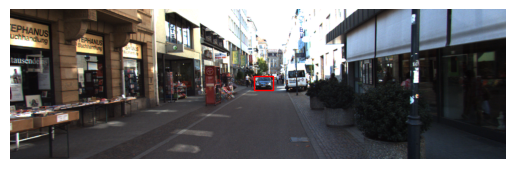

In [13]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(image, task_prompt, text_input="a car down the street")
print(results)
bbox = getBBOXFromPolygon(results["<REFERRING_EXPRESSION_SEGMENTATION>"])
print(bbox)
fig, ax = plot_bbox_raw(image, bbox)
fig.show()

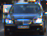

In [14]:
cropped_image = image.crop(bbox)
cropped_image

In [19]:
task_prompt = '<CAPTION>'
results = run_example(image, task_prompt)
results

{'<CAPTION>': 'A city street filled with lots of shops and people.'}